# Investigate results of fitting procedure

In [2]:
import sys
sys.path.append("../python/")
#sys.path.append("../python/cluster/")


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
#import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde, binned_statistic
import pickle
from matplotlib.offsetbox import AnchoredText
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM
from scipy.interpolate import griddata
import matplotlib.colors as colors
import utils_plots
imp.reload(utils_plots)
#from utils_plots import plot_FSE_grid_f_gamma_ex1, plot_1Dposterior_ex1, plot_FSE_grid_f_gamma_ex2, plot_1Dposterior_ex1_f, plot_1Dposterior_ex1_gamma
from utils import gNFW_rho
import pickle

import imp
import utils_plots
imp.reload(utils_plots)
from utils_plots import grid_FSE, grid_FSE_all, grid_coverage_all

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
#rc('text', usetex=True)

## Reconstruction for $f=1$, $\gamma=1.5$ and $r_s=5$ kpc

Text(0.5, 0, '$r_s$ [kpc]')

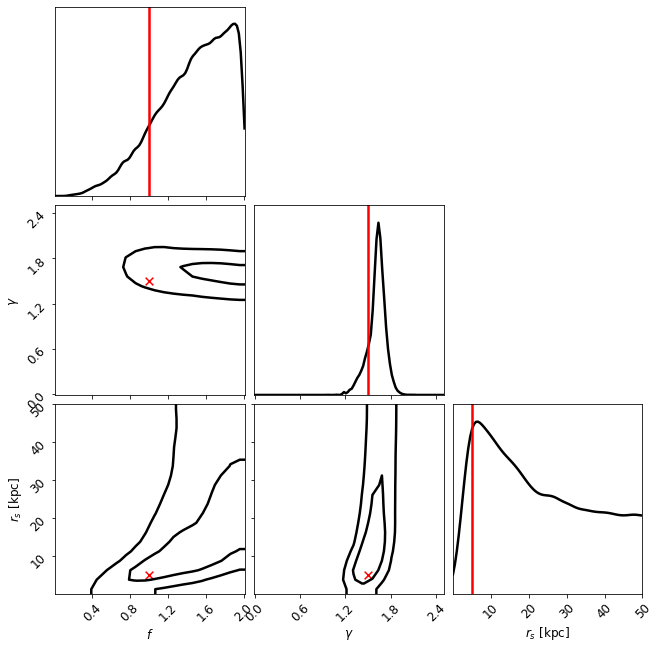

In [104]:
nBDs     = 100 ; sigma= 0.1
f        = 1.; gamma    = 1.5; rs = 5.

filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/N100sigma0.1/")
_file    = open(filepath + ("like_ex1_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv37" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/N100sigma0.1/")
_file    = open(filepath + ("posterior_ex1_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv37" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.01, 2.01), (-0.01, 2.5), (0., 50.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="r", ls="-", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="-", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="-", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

## Reconstruction for $f=1$, $\gamma=1.5$ and $r_s=20$ kpc

[0.05055054 0.09911669 0.14768284 0.19624899 0.24481514 0.29338129
 0.34194744 0.39051359 0.43907974 0.48764589 0.53621204 0.5847782
 0.63334435 0.6819105  0.73047665 0.7790428  0.82760895 0.8761751
 0.92474125 0.9733074  1.02187355 1.0704397  1.11900585 1.167572
 1.21613815 1.2647043  1.31327045 1.3618366  1.41040275 1.4589689
 1.50753505 1.5561012  1.60466735 1.6532335  1.70179965 1.7503658
 1.79893195 1.8474981  1.89606425 1.9446304  1.99319655 2.0417627
 2.09032885 2.138895   2.18746115 2.2360273  2.28459345 2.3331596
 2.38172575 2.4302919  2.47885805] [-45.9680267  -46.6859639  -45.59102739 -45.73767502 -44.08309633
 -45.66878265 -44.97138742 -46.43076096 -45.44728329 -45.50379723
 -46.23124586 -46.0156713  -46.03255277 -45.3109674  -44.76059962
 -45.21030421 -44.80869377 -44.38035859 -44.41005439 -44.47240382
 -44.69426816 -44.81529218 -44.81052725 -44.80753861 -44.79843947
 -44.83041841 -44.90047342 -44.97697496 -45.08221946 -45.15968072
 -45.24303868 -45.32472345 -45.41855109 -

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


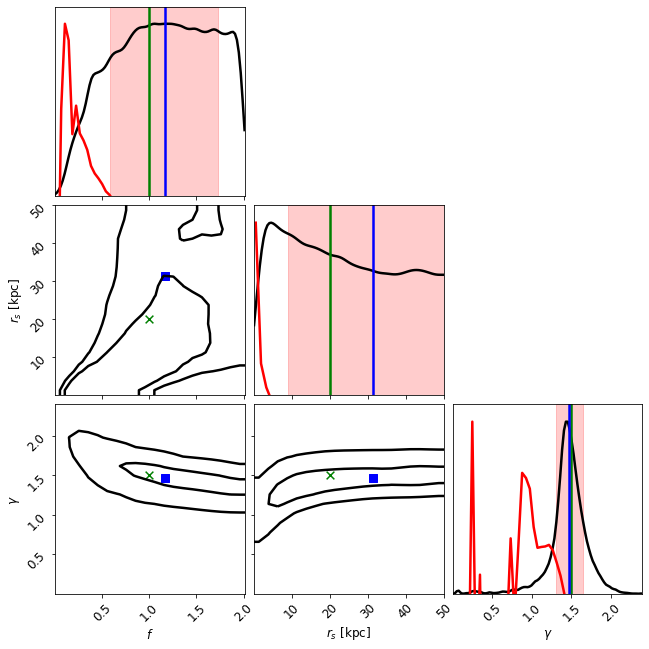

In [2]:
nBDs     = 100 ; sigma= 0.1
f        = 1.; gamma    = 1.5; rs = 20.

filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/check/N100sigma0.1/")
_file    = open(filepath + ("like_checkT_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv31" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/check/N100sigma0.1/")
_file    = open(filepath + ("posterior_checkT_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv31" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 2.01), (0., 50.), (0., 2.4)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")


bin_n=50
x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))

#print(x, y)
#print(" ===== ")

axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]

print(x, y)

y = y - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

#axes[2, 2].set_yscale("log")

#fig.savefig("fixedT100K_posterior_nBDs1000_sigma0.1_gamma1.5_rs20.pdf", bbox_inches="tight")

**Study the effect of samples discreteness in likelihood computation**

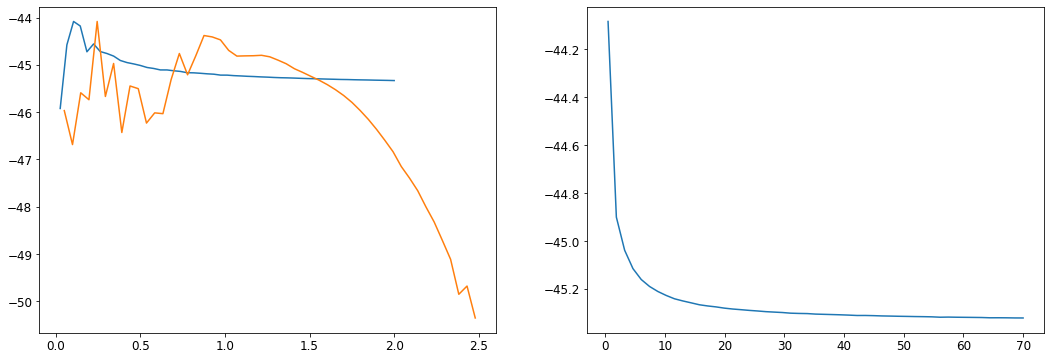

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]

ax[0].plot(x, y)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]

ax[0].plot(x, y)

x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]

ax[1].plot(x, y)

## Study the effect of the priors

**Uniform priors but gamma only up to 2**

0.010041561828150844 69.99769141296726    -10.151324188438025 1.0
0.0012168436249384573 1.999996080433541    0.429599938988531 1.0
0.01000023808390152 0.8488012664201676    -19.88974761659489 1.0


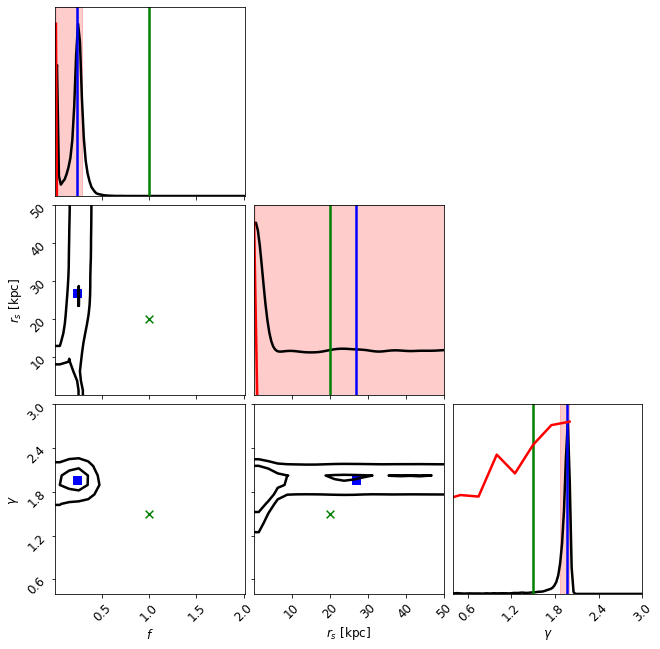

In [109]:
nBDs     = 1000 ; sigma= 0.3
f        = 1.; gamma = 1.5; rs = 20.
nwalkers = 50; steps = 4000

filepath = ("/home/mariacst/exoplanets/running/checks/")
_file    = open(filepath + ("like_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
like     = pickle.load(_file)
_file    = open(filepath + ("posterior_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 2.01), (0., 50.), (0.4, 3.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

#fig.savefig("fixedT100K_posterior_nBDs100_sigma0.3_gamma1.5_rs20.pdf", bbox_inches="tight")

**Uniform priors - standard case**

0.013944677081084933 69.99612116926369    0.9706455697606202 1.0
0.7619874765387677 2.9999468513201073    -8.022127187391362 1.0
0.010001752611724812 1.9976880204743042    -5.500321077305813 1.0


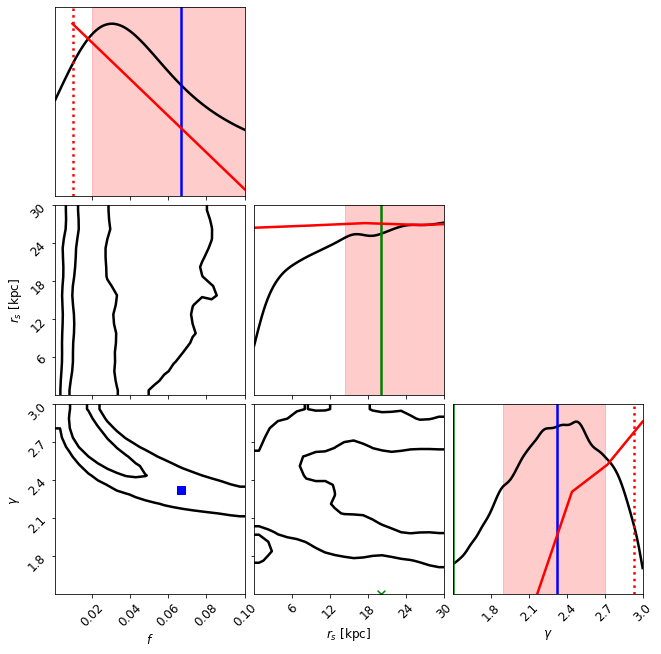

In [35]:
nBDs     = 100 ; sigma= 0.3
f        = 1.; gamma    = 1.5; rs = 20.

filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/check/N100sigma0.3/")
_file    = open(filepath + ("like_checkT_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv31" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/check/N100sigma0.3/")
_file    = open(filepath + ("posterior_checkT_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv31" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 0.1), (0., 30.), (1.5, 3.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

0.029616035049505385 69.99791928903073    0.8928534655125873 1.0
1.5489170474165623 2.9995995194680196    -21.027082994048044 1.0
0.010000205691290507 0.9278851338477809    -24.360137372069175 1.0


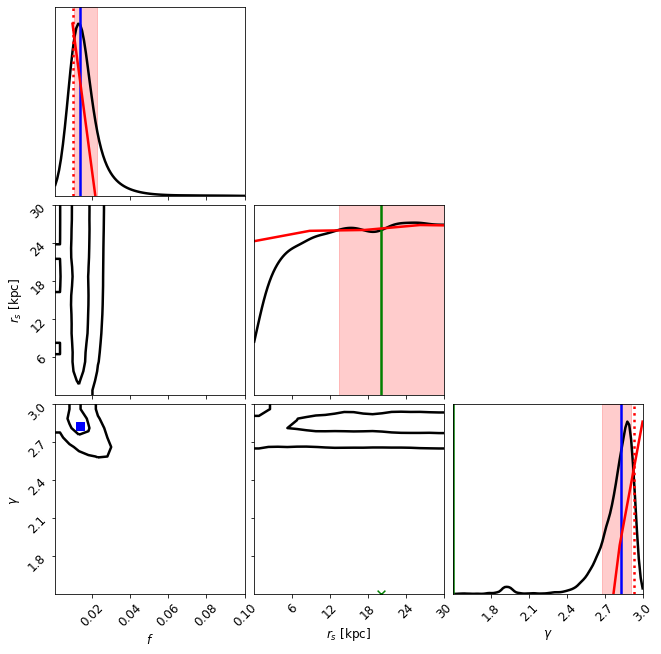

In [27]:
nBDs     = 1000 ; sigma= 0.3
f        = 1.; gamma    = 1.5; rs = 20.
nwalkers=50; steps=4000

filepath = ("/home/mariacst/exoplanets/running/checks/results/")
_file    = open(filepath + ("like_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
like     = pickle.load(_file)
_file    = open(filepath + ("posterior_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 0.1), (0., 30.), (1.5, 3.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls=":", lw=2.5, color="r"); 
axes[1, 1].axvline(ML[2], ls=":", lw=2.5, color="r");
axes[2, 2].axvline(ML[1], ls=":", lw=2.5, color="r");

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

#fig.savefig("fixedT100K_posterior_nBDs100_sigma0.3_gamma1.5_rs20.pdf", bbox_inches="tight")

**Log prior in rs and f**

-1.9999244117852688 1.8498485220540668    0.9705456758359716 1.0
6.968438734888949e-05 2.999986118992608    0.8373864784618448 1.0
0.01000019615007797 1.9948180408244751    0.1344190263401046 1.0


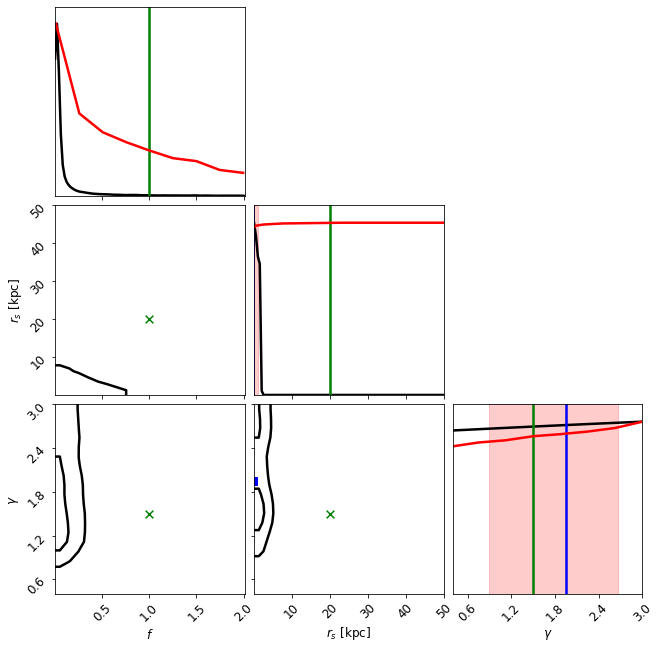

In [118]:
nBDs     = 1000 ; sigma= 0.3
f        = 1.; gamma    = 1.5; rs = 20.

filepath = ("/home/mariacst/exoplanets/running/checks/")
_file    = open(filepath + ("like_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_log" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
_file    = open(filepath + ("posterior_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_log" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([np.power(10, samples[:, 0]), samples[:, 2], np.power(10, samples[:, 1])]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 2.01), (0., 50.), (0.4, 3.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([np.power(10, samples[:, 0]), samples[:, 2], np.power(10, samples[:, 1])])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(np.power(10, x), y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(np.power(10, samples[:, 0]), like, 'max', bins=bin_n)[1] 
y = binned_statistic(np.power(10, samples[:, 0]), like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

1.1694885517432874 2.348187070827299    -2.052627584836415 1.0
0.7717664515500751 69.99876967168707    0.9900655982229196 1.0
0.03268054554763922 1.999843911504107    -0.9866171517072857 1.0
0.5256833833934885 1.7680445196251378 57.367538396615664


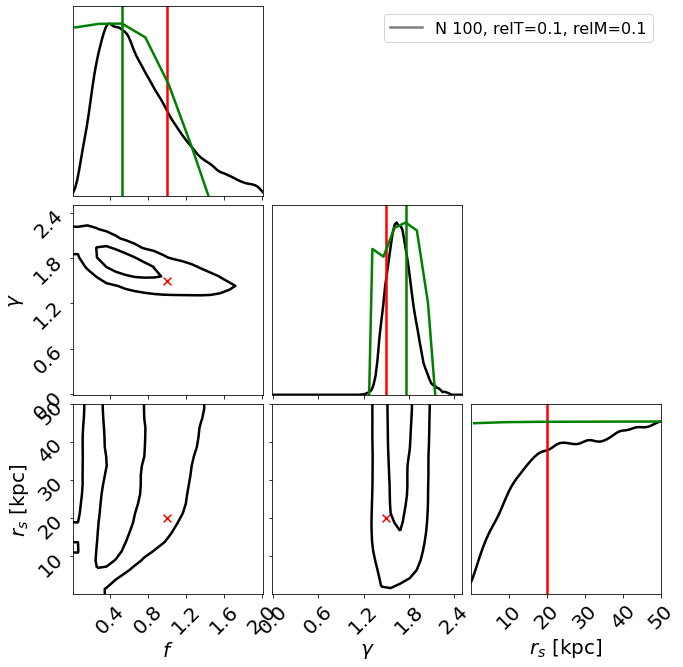

In [15]:
nBDs     = 100 ; sigma= 0.1
f        = 1.; gamma    = 1.5; rs = 20.

filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/N100sigma0.1/")
_file    = open(filepath + ("like_ex1_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv77" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/N100sigma0.1/")
_file    = open(filepath + ("posterior_ex1_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv77" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.01, 2.01), (-0.01, 2.5), (0., 50.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="r", ls="-", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="-", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="-", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

colors = ['grey']
lines = [Line2D([0], [0], color=c, linewidth=2.5, linestyle='-') for c in colors]
labels = ['N %i, relT=%.1f, relM=%.1f' %(nBDs, relT, relM)]
axes[0, 2].legend(lines, labels, fontsize=16)

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="-", lw=2.5, color="g"); 
axes[1, 1].axvline(ML[1], ls="-", lw=2.5, color="g");
axes[2, 2].axvline(ML[2], ls="-", lw=2.5, color="g");

bin_n=8
x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="green", lw=2.5)

x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="green", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="green", lw=2.5)

print(ML[0], ML[1], ML[2])

## Fixed velocity DM particles to $v=100$ km/s & $\sigma_T=100$ K

../python/utils_plots.py:486: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:491: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


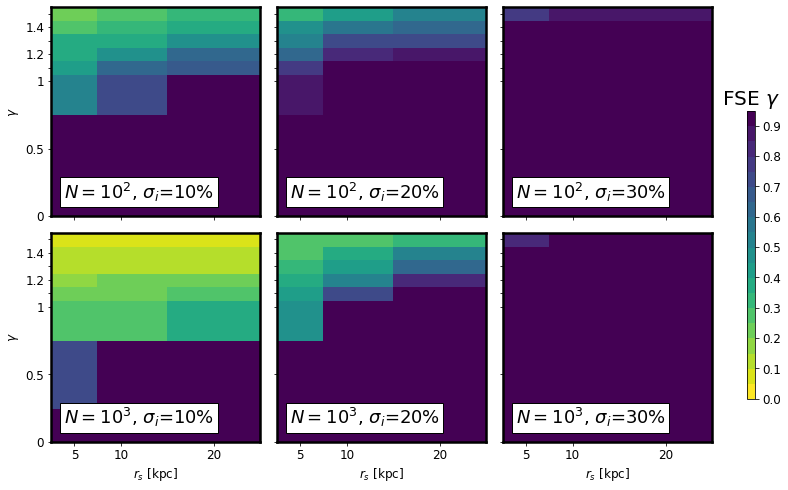

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
PE   = "ML"
ex   = "fixedT100K_nwalkers100"
im   = grid_FSE_all(path, 100, 0.1, ex, ax[0, 0], PE, False, True, True, False)
im   = grid_FSE_all(path, 1000, 0.1, ex, ax[1, 0], PE, False, True, True, True)
im   = grid_FSE_all(path, 100, 0.2, ex, ax[0, 1], PE, False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.2, ex, ax[1, 1], PE, False, True, False, True)
im   = grid_FSE_all(path, 100, 0.3, ex, ax[0, 2], PE, False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.3, ex, ax[1, 2], PE, False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("fixedT100K_nwalkers100_FSE_" + PE + "_gamma.pdf", bbox_inches="tight")

../python/utils_plots.py:486: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:491: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


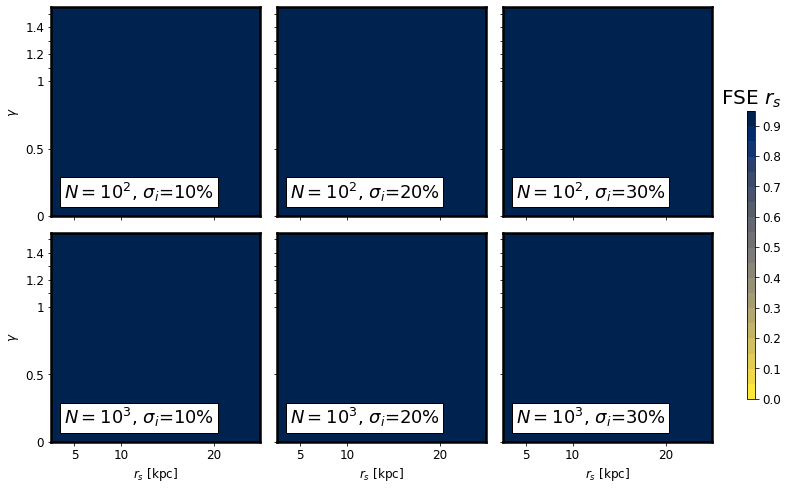

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
PE   = "ML"
ex   = "fixedT100K_nwalkers100"
im   = grid_FSE_all(path, 100, 0.1, ex, ax[0, 0], PE, False, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, ex, ax[1, 0], PE, False, False, True, True)
im   = grid_FSE_all(path, 100, 0.2, ex, ax[0, 1], PE, False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, ex, ax[1, 1], PE, False, False, False, True)
im   = grid_FSE_all(path, 100, 0.3, ex, ax[0, 2], PE, False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.3, ex, ax[1, 2], PE, False, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("fixedT100K_nwalkers100_FSE_" + PE + "_rs.pdf", bbox_inches="tight")

../python/utils_plots.py:857: UserWarning: The following kwargs were not used by contour: 'color'
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:872: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:877: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


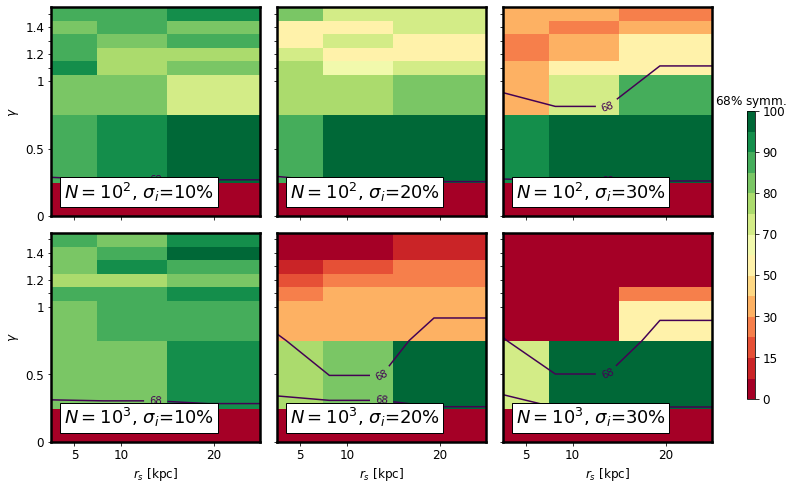

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
CR   = "LI"
ex   = "fixedT100K_nwalkers100"
im   = grid_coverage_all(path, 100, 0.1, ex, ax[0, 0], CR, False, True, True, False)
im   = grid_coverage_all(path, 1000, 0.1, ex, ax[1, 0], CR, False, True, True, True)
im   = grid_coverage_all(path, 100, 0.2, ex, ax[0, 1], CR, False, True, False, False)
im   = grid_coverage_all(path, 1000, 0.2, ex, ax[1, 1], CR, False, True, False, True)
im   = grid_coverage_all(path, 100, 0.3, ex, ax[0, 2], CR, False, True, False, False)
im   = grid_coverage_all(path, 1000, 0.3, ex, ax[1, 2],CR, False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"68$\%$ symm.", size=12.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("fixedT100K_nwalkers100_coverage_" + CR + "_gamma.pdf", bbox_inches="tight")

../python/utils_plots.py:868: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:868: UserWarning: The following kwargs were not used by contour: 'color'
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:872: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:877: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


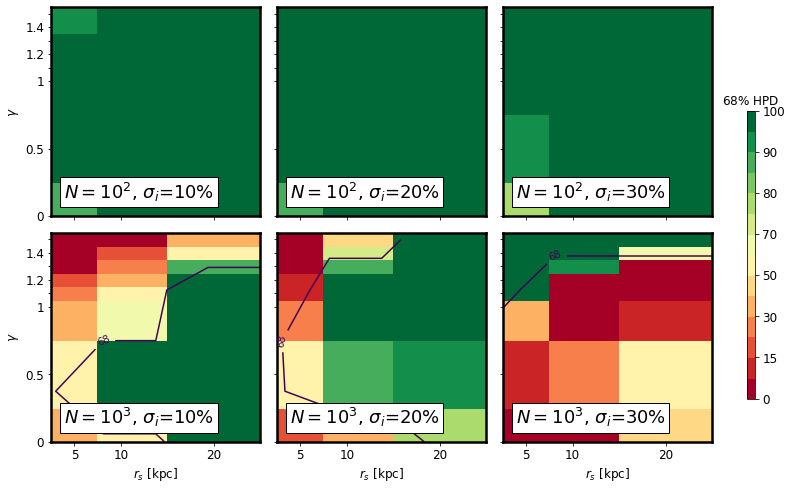

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
CR   = "LI"
ex   = "fixedT100K_nwalkers100"
im   = grid_coverage_all(path, 100, 0.1, ex, ax[0, 0], CR, False, False, True, False)
im   = grid_coverage_all(path, 1000, 0.1, ex, ax[1, 0],CR, False, False, True, True)
im   = grid_coverage_all(path, 100, 0.2, ex, ax[0, 1], CR, False, False, False, False)
im   = grid_coverage_all(path, 1000, 0.2, ex, ax[1, 1],CR, False, False, False, True)
im   = grid_coverage_all(path, 100, 0.3, ex, ax[0, 2], CR, False, False, False, False)
im   = grid_coverage_all(path, 1000, 0.3, ex, ax[1, 2],CR, False, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"68$\%$ HPD", size=12.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig("fixedT100K_coverage_" + CR + "_rs.pdf", bbox_inches="tight")

### Reconstruction properties for different point estimates

In [11]:
imp.reload(utils_plots)
from utils_plots import FSE_f_gamma_rs, MSE_f_gamma_rs

Text(0, 0.5, 'FSE $\\gamma$')

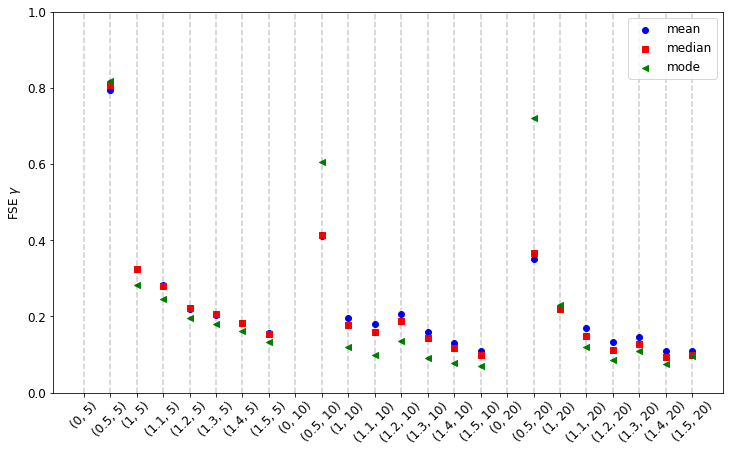

In [16]:
path = "/home/mariacst/exoplanets/results/velocity/v100/"
ex   = "checkT"
nBDs = 100
sigma = 0.1

gamma = [0., 0.5, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
rs    = [5, 10, 20]
x     = np.linspace(0, 1, 24)

PE     = ["mean", "median", "mode"]
color  = ["blue", "red", "green"]
marker = ["o", "s", "<"]

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
i = 0
for pe in PE:
    xi, yi, _, zi_2, _ = FSE_f_gamma_rs(path, nBDs, sigma, ex, rank=100, PE=pe)
    
    ax.scatter(x, np.ravel(zi_2), color=color[i], marker=marker[i], label=pe)
    i+=1
    
for i in x:
    ax.axvline(i, ls="--", alpha=0.2, color="k")

ax.legend()
ax.set_xticks(x)    
ax.set_xticklabels(['(0, 5)', '(0.5, 5)', '(1, 5)', '(1.1, 5)', '(1.2, 5)', '(1.3, 5)', 
                    '(1.4, 5)', '(1.5, 5)', '(0, 10)', '(0.5, 10)', '(1, 10)', '(1.1, 10)', '(1.2, 10)', 
                    '(1.3, 10)', '(1.4, 10)', '(1.5, 10)', '(0, 20)', '(0.5, 20)', '(1, 20)', '(1.1, 20)', 
                    '(1.2, 20)', '(1.3, 20)', '(1.4, 20)', '(1.5, 20)'], 
                   rotation=45);

ax.set_ylim(0, 1.)
ax.set_ylabel(r"FSE $\gamma$")

Text(0, 0.5, 'MSE $\\gamma$')

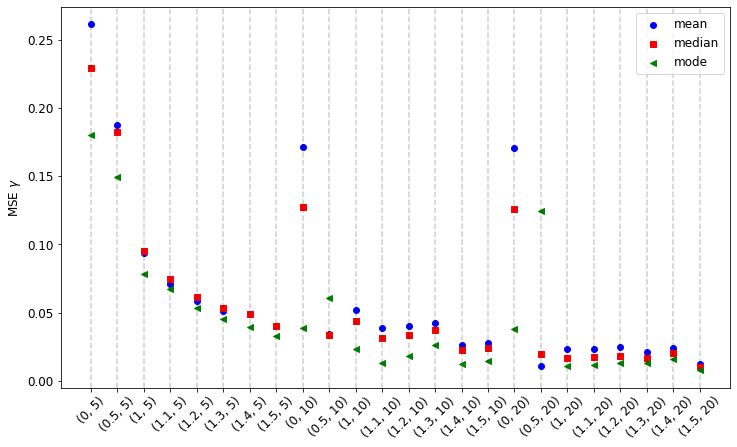

In [17]:
path = "/home/mariacst/exoplanets/results/velocity/v100/"
ex   = "ex1"
nBDs = 100
sigma = 0.1

gamma = [0., 0.5, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
rs    = [5, 10, 20]
x     = np.linspace(0, 1, 24)

PE     = ["mean", "median", "mode"]
color  = ["blue", "red", "green"]
marker = ["o", "s", "<"]

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
i = 0
for pe in PE:
    xi, yi, _, zi_2, _, MSE_2 = MSE_f_gamma_rs(path, nBDs, sigma, ex, rank=100, PE=pe)
    
    ax.scatter(x, np.ravel(zi_2), color=color[i], marker=marker[i], label=pe)
    i+=1
    
for i in x:
    ax.axvline(i, ls="--", alpha=0.2, color="k")

ax.legend()
ax.set_xticks(x)    
ax.set_xticklabels(['(0, 5)', '(0.5, 5)', '(1, 5)', '(1.1, 5)', '(1.2, 5)', '(1.3, 5)', 
                    '(1.4, 5)', '(1.5, 5)', '(0, 10)', '(0.5, 10)', '(1, 10)', '(1.1, 10)', '(1.2, 10)', 
                    '(1.3, 10)', '(1.4, 10)', '(1.5, 10)', '(0, 20)', '(0.5, 20)', '(1, 20)', '(1.1, 20)', 
                    '(1.2, 20)', '(1.3, 20)', '(1.4, 20)', '(1.5, 20)'], 
                   rotation=45);

#ax.set_ylim(0, 1.)
ax.set_ylabel(r"MSE $\gamma$")

Text(0, 0.5, 'FSE $r_s$')

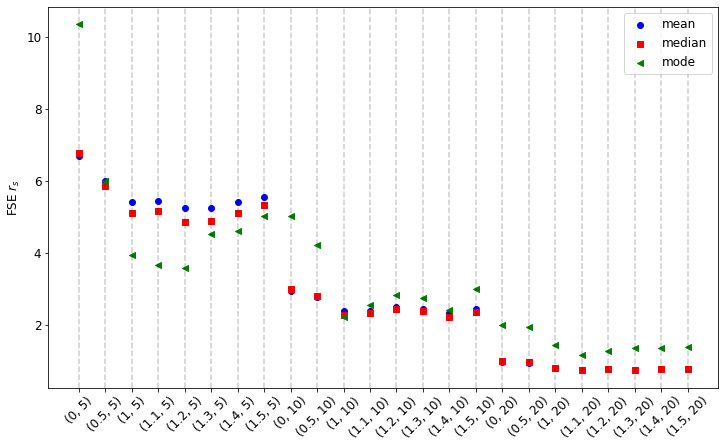

In [23]:
path = "/home/mariacst/exoplanets/results/velocity/v100/"
ex   = "checkT"
nBDs = 100
sigma = 0.1

gamma = [0., 0.5, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
rs    = [5, 10, 20]
x     = np.linspace(0, 1, 24)

PE     = ["mean", "median", "mode"]
color  = ["blue", "red", "green"]
marker = ["o", "s", "<"]

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
i = 0
for pe in PE:
    xi, yi, _, _, zi_3 = FSE_f_gamma_rs(path, nBDs, sigma, ex, rank=100, PE=pe)
    
    ax.scatter(x, np.ravel(zi_3), color=color[i], marker=marker[i], label=pe)
    i+=1
    
for i in x:
    ax.axvline(i, ls="--", alpha=0.2, color="k")

ax.legend()
ax.set_xticks(x)    
ax.set_xticklabels(['(0, 5)', '(0.5, 5)', '(1, 5)', '(1.1, 5)', '(1.2, 5)', '(1.3, 5)', 
                    '(1.4, 5)', '(1.5, 5)', '(0, 10)', '(0.5, 10)', '(1, 10)', '(1.1, 10)', '(1.2, 10)', 
                    '(1.3, 10)', '(1.4, 10)', '(1.5, 10)', '(0, 20)', '(0.5, 20)', '(1, 20)', '(1.1, 20)', 
                    '(1.2, 20)', '(1.3, 20)', '(1.4, 20)', '(1.5, 20)'], 
                   rotation=45);

#ax.set_ylim(0, 1.)
ax.set_ylabel(r"FSE $r_s$")

Text(0, 0.5, 'MSE $r_s$')

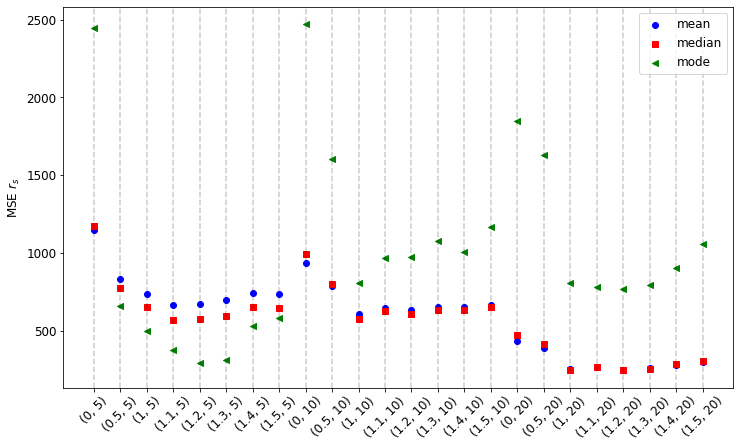

In [21]:
path = "/home/mariacst/exoplanets/results/velocity/v100/"
ex   = "ex1"
nBDs = 100
sigma = 0.1

gamma = [0., 0.5, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
rs    = [5, 10, 20]
x     = np.linspace(0, 1, 24)

PE     = ["mean", "median", "mode"]
color  = ["blue", "red", "green"]
marker = ["o", "s", "<"]

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
i = 0
for pe in PE:
    xi, yi, _, _, zi_3, _ = MSE_f_gamma_rs(path, nBDs, sigma, ex, rank=100, PE=pe)
    
    ax.scatter(x, np.ravel(zi_3), color=color[i], marker=marker[i], label=pe)
    i+=1
    
for i in x:
    ax.axvline(i, ls="--", alpha=0.2, color="k")

ax.legend()
ax.set_xticks(x)    
ax.set_xticklabels(['(0, 5)', '(0.5, 5)', '(1, 5)', '(1.1, 5)', '(1.2, 5)', '(1.3, 5)', 
                    '(1.4, 5)', '(1.5, 5)', '(0, 10)', '(0.5, 10)', '(1, 10)', '(1.1, 10)', '(1.2, 10)', 
                    '(1.3, 10)', '(1.4, 10)', '(1.5, 10)', '(0, 20)', '(0.5, 20)', '(1, 20)', '(1.1, 20)', 
                    '(1.2, 20)', '(1.3, 20)', '(1.4, 20)', '(1.5, 20)'], 
                   rotation=45);

#ax.set_ylim(0, 1.)
ax.set_ylabel(r"MSE $r_s$")

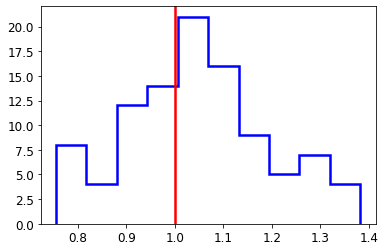

In [53]:
data = np.genfromtxt(path + "statistics_ex1_N100_sigma0.1_f1.0gamma%.1frs%.1f" %(1, 20), unpack=True)

pe = data[1]

fig, ax = plt.subplots()

ax.hist(pe, histtype="step", color="blue", lw=2.5);
ax.axvline(1., color="red", lw=2.5)

## HPD w/ pymc3 statistics

I get an error when running in terminal!

In [78]:
from pymc3.stats import hpd

In [96]:
filepath = "/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/"
nBDs=100; rel_unc=0.1; f=1.; gamma=1.5; rs=20.

hpd_1sigma = []

for i in range(100):
    file_name  = (filepath + ("N%isigma%.1f/posterior_" %(nBDs, rel_unc))   
                 + ex +                                                        
                 ("_N%i_sigma%.1f_f%.1fgamma%.1frs%.1fv%i"                     
                 %(nBDs, rel_unc, f, gamma, rs, i+1)))                         
    samples    = pickle.load(open(file_name, "rb")) 
    hpd_1sigma.append(hpd(samples, alpha=0.32))
    
hpd_1sigma = np.array(hpd_1sigma)
print(hpd_1sigma.shape)

(100, 3, 2)


In [102]:
rank=99
print(hpd_1sigma[rank])
print(hpd_1sigma[rank][2, 1])

[[ 0.14358159  0.9648952 ]
 [ 1.42184592  1.81377713]
 [23.7474298  66.63239129]]
66.63239128846016


In [86]:
print(hpd_1sigma.shape)

(3, 100)


In [91]:
D=3;rank=100
hpd_1sigma = np.zeros((D, rank))
print(hpd(samples, alpha=0.32))
print(hpd(samples, alpha=0.32).shape)


array([[ 0.14358159,  0.9648952 ],
       [ 1.42184592,  1.81377713],
       [23.7474298 , 66.63239129]])